In [1]:
import os
import json
import grain
import jax
import jax.numpy as jnp
import random
from functools import partial
import numpy as np

In [2]:
# {'train': [{'input': [[2, 0, 2], [0, 2, 0], [2, 0, 2]], 'output': [[1]]},
#   {'input': [[2, 0, 0], [2, 0, 0], [0, 2, 0]], 'output': [[7]]},
#   {'input': [[2, 0, 2], [2, 0, 2], [2, 0, 2]], 'output': [[1]]},
#   {'input': [[0, 0, 0], [2, 0, 2], [0, 0, 0]], 'output': [[1]]},
#   {'input': [[2, 2, 0], [0, 2, 2], [0, 0, 0]], 'output': [[7]]},
#   {'input': [[2, 2, 0], [0, 2, 0], [0, 0, 0]], 'output': [[7]]}],
#  'test': [{'input': [[2, 0, 2], [2, 2, 2], [2, 0, 2]], 'output': [[1]]},
#   {'input': [[0, 0, 0], [2, 0, 0], [2, 0, 0]], 'output': [[7]]}]}

In [3]:
class JsonDataSource(grain.sources.RandomAccessDataSource):
    def __init__(self, folder):
        self.file_paths = [
            os.path.join(folder, f) 
            for f in os.listdir(folder) 
            if f.endswith('.json')
        ]
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, index):
        with open(self.file_paths[index], 'r') as f:
            return json.load(f)


class Parse(grain.transforms.Map):
    def map(self, x):
        return {
            split: {
                xput: [jnp.array(sample[xput]) for sample in x[split]]
                for xput in ('input', 'output')
            }
            for split in ("train", "test")
        }

class D8Augmentation(grain.transforms.RandomMap):
    def __init__(self):
        self.ops = (
            lambda x: x,
            partial(jnp.rot90, k=1),
            partial(jnp.rot90, k=2),
            partial(jnp.rot90, k=3),
            jnp.fliplr,
            jnp.flipud,
            jnp.transpose,
            lambda x: jnp.transpose(jnp.rot90(x, k=1)),
        )

    def random_map(self, x, rng: np.random.Generator):
        fn = self.ops[rng.integers(0, 8).item()]
        return jax.tree.map(fn, x)

class ColourAugmentation(grain.transforms.RandomMap):
    def random_map(self, x, rng: np.random.Generator):
        colours = rng.permutation(10)
        x = jax.tree.map(lambda x: colours[x], x)
        return x


class Stack(grain.transforms.Map):
    def __init__(self, max_grid_size = 30, max_train_samples = 10, max_test_samples = 3):
        self.max_grid_size = max_grid_size
        self.max_train_samples = max_train_samples
        self.max_test_samples = max_test_samples
        
    def _pad_and_expand(self, x):
        padded = jnp.pad(
            x,
            pad_width=((0, self.max_grid_size - x.shape[0]), (0, self.max_grid_size - x.shape[1])),
            mode="constant",
            constant_values=-1
        )
        expanded = padded[jnp.newaxis, ...]
        return expanded
    
    def map(self, x):
        pad_sample = jnp.full((1, self.max_grid_size, self.max_grid_size), -1)
        train_pad_samples = [pad_sample for _ in range(self.max_train_samples - len(x["train"]['input']))]
        test_pad_samples = [pad_sample for _ in range(self.max_test_samples - len(x["test"]['input']))]
        return {
            split: {
                xput: jnp.vstack([self._pad_and_expand(sample) for sample in x[split][xput]] + pad_samples)
                for xput in ('input', 'output')
            }
            for split, pad_samples in zip(("train", "test"), (train_pad_samples, test_pad_samples))
        }
    

def get_data_loader(data_dir):

    data_source = JsonDataSource(data_dir)

    sampler = grain.samplers.IndexSampler(len(data_source), seed=0)

    operations = [
        Parse(),
        D8Augmentation(),
        ColourAugmentation(),
        Stack(),
        grain.transforms.Batch(batch_size=2)
    ]

    return grain.DataLoader(data_source=data_source, operations=operations, sampler=sampler)

In [4]:
source = JsonDataSource("data/training")
source[0]

{'train': [{'input': [[0, 0, 5], [0, 5, 0], [5, 0, 0]],
   'output': [[3, 3, 3], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
   'output': [[3, 3, 3], [3, 3, 3], [3, 3, 3]]},
  {'input': [[5, 0, 0], [0, 5, 0], [5, 0, 0]],
   'output': [[2, 2, 2], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
   'output': [[4, 4, 4], [3, 3, 3], [4, 4, 4]]}],
 'test': [{'input': [[0, 0, 5], [5, 0, 0], [0, 5, 0]],
   'output': [[3, 3, 3], [2, 2, 2], [4, 4, 4]]}]}

In [5]:
train_data_loader = get_data_loader("data/training")

In [6]:
sample = next(iter(get_data_loader("data/training")))
sample['train']['input'][0], sample['train']['output'][0]

(array([[[ 0,  0,  5, ..., -1, -1, -1],
         [ 0,  5,  0, ..., -1, -1, -1],
         [ 5,  0,  0, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],
 
        [[ 0,  0,  5, ..., -1, -1, -1],
         [ 0,  0,  5, ..., -1, -1, -1],
         [ 0,  0,  5, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],
 
        [[ 5,  0,  0, ..., -1, -1, -1],
         [ 0,  5,  0, ..., -1, -1, -1],
         [ 5,  0,  0, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],
 
        ...,
 
        [[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],


In [7]:
sample['train']['input'].shape, sample['train']['output'].shape, sample['test']['input'].shape, sample['test']['output'].shape

((2, 10, 30, 30), (2, 10, 30, 30), (2, 3, 30, 30), (2, 3, 30, 30))

In [14]:
source[0]

{'train': [{'input': [[0, 0, 5], [0, 5, 0], [5, 0, 0]],
   'output': [[3, 3, 3], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
   'output': [[3, 3, 3], [3, 3, 3], [3, 3, 3]]},
  {'input': [[5, 0, 0], [0, 5, 0], [5, 0, 0]],
   'output': [[2, 2, 2], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
   'output': [[4, 4, 4], [3, 3, 3], [4, 4, 4]]}],
 'test': [{'input': [[0, 0, 5], [5, 0, 0], [0, 5, 0]],
   'output': [[3, 3, 3], [2, 2, 2], [4, 4, 4]]}]}

In [15]:
train_l = []
test_l = []
for sample in source:
    train_l.append(len(sample['train']))
    test_l.append(len(sample['test']))


In [18]:
import matplotlib.pyplot as plt

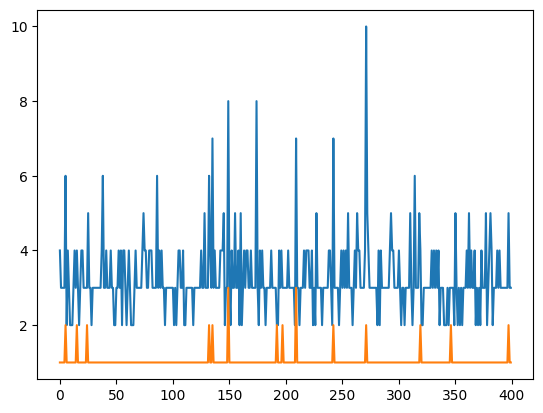

In [20]:
plt.plot(train_l)
plt.plot(test_l)   